In [ ]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import sys

GOAL FOR TDOAY -- TO DO:

- Plot vol smile for each of the respective option maturities - including calls and puts?
- Plot the vol term structure for a particular stock

Stretch: 
- Extend this to crypto markets and clean up the EDA on Deribit section
- Post the deribit EDA to the other github research notebook

In [37]:
class Data:
    def __init__(self, ticker, option_type='call', n=3):
        self.ticker = ticker
        self.option_type = option_type
        self.n = n
        
    def get_input_data(self):
        storage = []
        x = yf.Ticker(self.ticker)
        option_dates = x.options
        if len(option_dates) == 0:
            sys.exit("Ticker does not have any options. Please try another ticker")
            
        for date in tqdm(option_dates):
            try:
                call, put = x.option_chain(date)[0], x.option_chain(date)[1]
                call['option_type'], put['option_type'] = ('call', 'put')
                d = pd.concat([call, put])
                storage.append(d)
            except:
                pass
        df = pd.concat(storage)
        df = df.reset_index()
        df['maturity'] = pd.DataFrame([i[-15:-9] for i in df.contractSymbol])
        
        return df
    
    def plot_vol_smile(self):
        data = self.get_input_data()
        maturities = list(set(data.maturity))
        maturities.sort()
        
        for date in maturities:
            temp = data[(data.maturity == date) & (data.option_type == self.option_type)]
            
            title_date = datetime.date(2000 + int(date[:2]), int(date[2:4]), int(date[4:])).strftime("%B %d, %Y")
            
            plt.scatter(temp.strike, temp.impliedVolatility)
            plt.title(self.ticker.upper() + " " + self.option_type.upper() + ": " + title_date)
            plt.ylabel("Implied Volatility")
            plt.xlabel("Strike")
            plt.show()
        
        '''
        fig, axes = plt.subplots(nrows=round(len(maturities)/2) + 1, ncols=2, figsize=(15,30))
        fig.subplots_adjust(hspace=0.5)

        for ax, i, name, in zip(axes.flatten(), range(len(maturities)), maturities):
            temp = z[(z.maturity == maturities[i]) & (z.type==self.option_type)]   
            
            
            year = datetime.date(2000 + int(name[:2]), int(name[2:4]), int(name[4:])).strftime('%Y')
            month = datetime.date(2000 + int(name[:2]), int(name[2:4]), int(name[4:])).strftime('%B')
            day = int(name[4:])
            
            ax.scatter(temp.strike, temp.impliedVolatility)
            ax.set(title = month, xlabel='Strike')
        '''
        
        
    def plot_vol_term_structure(self):
        data = self.get_input_data()
        p = yf.Ticker(self.ticker).info
        mid_price = (p['ask'] + p['bid'])/2
        strikes = list(set(data.strike))
        maturities = list(set(data.maturity))

        get_closest_strike = min(range(len(strikes)), key=lambda i: abs(strikes[i]- mid_price))
        closest_ATM_indexes = list(range(get_closest_strike - self.n,
                                         get_closest_strike + self.n))
        closest_ATM_strikes = [strikes[i] for i in closest_ATM_indexes]
        storage = []
        for date in maturities:
            try: # NOTE - THE CALLS AND PUTS HERE ARE SEPERATED OUT - LOOK INTO HOW TO INCLUDE BOTH
                temp = data[(data.maturity == date) & (data.option_type== self.option_type)]
                storage.append(temp[temp['strike'].isin(closest_ATM_strikes)].mean()['impliedVolatility'])
            except:
                continue
        df = pd.DataFrame([maturities, storage]).T
        df = df.sort_values(0)
        df = df.dropna()
        plt.plot(df[0], df[1])
        plt.show()

In [38]:
d = Data("aapl", 'call', n=2)

100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


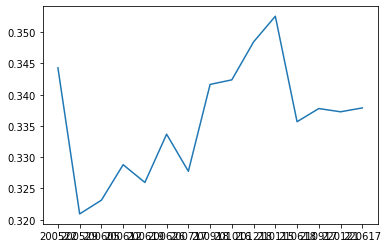

In [39]:
d.plot_vol_term_structure()

In [ ]:
class Data:
    def __init__(self, ticker, n):
        self.base_url = "https://query2.finance.yahoo.com/v7/finance/options/" + str(ticker)
        self.n = n
        
    def get_input_data(self):
        # Get required input data for the options values
        r = requests.get(self.base_url).json()
        data = r['optionChain']['result'][0]
        dates = data['expirationDates']
        strikes = data['strikes']
        mid_price = np.mean([data['quote']['bid'], data['quote']['ask']])
        
        # Filter for closest ATM strikes
        get_closest_strike = min(range(len(strikes)), key=lambda i: abs(strikes[i]- mid_price))
        
        closest_ATM_indexes = list(range(get_closest_strike - self.n, 
                                         get_closest_strike + self.n))
        
        closest_ATM_strikes = [strikes[i] for i in closest_ATM_indexes]
        
        return dates, closest_ATM_strikes

    
    def get_vol_data(self):
        # Now iterate through each date and get the mean IV for the closest ATM strikes
        dates = self.get_input_data()[0]
        atm_strikes = self.get_input_data()[1]
        key = ['calls', 'puts']
        
        mean_implied_vol = []
        
        for date in tqdm(dates):
            try:
                url = self.base_url + "?date=" + str(date)
                print(date)
                data = requests.get(url).json()['optionChain']['result'][0]['options'][0]
                options = [data.get(key) for key in keys]
                calls, puts = pd.DataFrame(options[0]), pd.DataFrame(options[1])
                df = pd.concat([calls, puts], axis=0)
                mean_implied_vol.append(df[df['strike'].isin(atm_strikes)].mean()['impliedVolatility'])
            except:
                continue

        return dates, mean_implied_vol
